In [2]:
import cooltools
import cooler
import pandas as pd
import bioframe
import numpy as np
import pyBigWig
import bbi
import copy

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
from cooltools import expected_cis, expected_trans
from cooltools.lib import plotting

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [7]:
# 读取mcools 文件
gm_matrix_file = "/data1/ZJY/GpC/Analysis/GM12878/juicematrix/GM12878_GpC.mcool::/resolutions/10000" # 10kb
k562_matrix_file = "/data1/ZJY/GpC/Analysis/K562/MergeK562/juicematrix/K562_merge_gpc.mcool::/resolutions/10000"

c1 = cooler.Cooler(gm_matrix_file)
c2 = cooler.Cooler(k562_matrix_file)

# gpc peaks
# Peak loading and  Interaction loading
peakfile = "/data1/Project/GpC/Fiugres/Fig2/process_data/GC_Peaks.txt"
gmpeakdf = pd.read_csv(peakfile, header=None, index_col=None, sep="\t",
                     names=["chrom","start", "end", "ID", "length", "meanGpC" ], 
                     usecols=[0,1,2,3,4,7])

peakfile = "/data1/Project/GpC/Fiugres/Fig2/process_data/K_GC_Peaks.txt" # K562 GpC peaks
k562peakdf = pd.read_csv(peakfile, header=None, index_col=None, sep="\t",
                     names=["chrom","start", "end", "ID", "length", "meanGpC" ], 
                     usecols=[0,1,2,3,4,7])

In [8]:
# Bigwig
def Meanval(df, bw, flank=250):
    '''
    chrom and mid columns in df
    '''
    meanval = []
    for n,row in df.iterrows():
        chrom, mid = row["chrom"], row["mid"] 
        meanval.append( bw.stats(chrom, mid-flank, mid+flank, type="mean", exact=True)[0] )
    return(meanval)

gmbigfile = "/data1/ZJY/GpC/Analysis/CpGGpC/GM12878_Integrated_GpC.bigWig"
gmbw = pyBigWig.open(gmbigfile)
# flank = 250
# gmpeakdf["mid"] = (gmpeakdf["start"] + gmpeakdf["end"])//2
# gmpeakdf["meanGpC"] = Meanval(gmpeakdf, gmbw, 250)

In [9]:
gmpeakdf

,chrom,start,end,ID,length,meanGpC
0,chr1,88245,88487,Integrated_8,242,0.305491
1,chr1,625998,626769,Integrated_20,771,0.527585
2,chr1,626885,630644,Integrated_21,3759,0.828216
3,chr1,630710,632301,Integrated_22,1591,0.980163
4,chr1,632367,632813,Integrated_23,446,0.974572
...,...,...,...,...,...,...
80025,chrX,155572926,155572961,Integrated_119116,35,0.242630
80026,chrX,155612904,155613020,Integrated_119119,116,0.342837
80027,chrX,155881213,155881359,Integrated_119122,146,0.325473
80028,chrX,155881544,155881593,Integrated_119123,49,0.373349


In [9]:
# BroadHmmGM12878
Hmmfile = "/data1/ZJY/GpC/Analysis/Annotation/EncodeBroadHmm/wgEncodeBroadHmmGm12878HMM_hg38.bed"
Hmmdf = pd.read_csv(Hmmfile, sep="\t", header=None, index_col=None, 
                   usecols=[0,1,2,3], names=["chrom", "start", "end", "Type"])

Hmmdf["Type"]  = Hmmdf["Type"].str.replace("[0-9]+_", "")
sTypes = ['Active_Promoter', 'Weak_Promoter', 'Poised_Promoter', \
          'Strong_Enhancer', 'Weak_Enhancer', 'Repressed', 'Heterochrom/lo']
Hmmdf = Hmmdf.loc[Hmmdf["Type"].isin(sTypes), :]
Hmmdf

,chrom,start,end,Type
1,chr1,10600,11137,Heterochrom/lo
4,chr1,11937,12137,Weak_Enhancer
11,chr1,27537,28537,Weak_Promoter
12,chr1,28537,29737,Active_Promoter
13,chr1,29737,30137,Weak_Promoter
...,...,...,...,...
570540,chrX,156013941,156014141,Strong_Enhancer
570541,chrX,156014141,156014941,Weak_Enhancer
570543,chrX,156016141,156016941,Weak_Promoter
570544,chrX,156016941,156017341,Weak_Enhancer


In [10]:
# bioframe
hg38_chromsizes=bioframe.fetch_chromsizes("hg38")
hg38_chromsizes = hg38_chromsizes[ hg38_chromsizes.index !='chrM']
hg38_cens = bioframe.fetch_centromeres("hg38")
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.loc[hg38_arms["chrom"].isin(c1.chromnames), :]
hg38_arms.head()

,chrom,start,end,name
0,chr1,0,123400000,chr1_p
1,chr1,123400000,248956422,chr1_q
2,chr2,0,93900000,chr2_p
3,chr2,93900000,242193529,chr2_q
4,chr3,0,90900000,chr3_p


In [11]:
# 随机选择 11000 个 1kb 大小的区间
import random
random.seed(1)
def generate_random_regions(chromsizes, region_size, n_regions):
    random_regions = []
    totalsizes = sum(chromsizes)
    for chrom, size in chromsizes.items():
        chrNs = int( n_regions*(size/totalsizes) ) 
        for _ in range(chrNs):
            start = np.random.randint(0, size - region_size + 1)
            end = start + region_size
            random_regions.append((chrom, start, end))
    return pd.DataFrame(random_regions, columns=['chrom', 'start', 'end'])

Ns = 10015
random_regions = generate_random_regions(hg38_chromsizes, 1000, Ns)
random_regions

,chrom,start,end
0,chr1,183462067,183463067
1,chr1,142184222,142185222
2,chr1,216347266,216348266
3,chr1,216300522,216301522
4,chr1,161336015,161337015
...,...,...,...
9996,chrY,41297520,41298520
9997,chrY,6866305,6867305
9998,chrY,45032241,45033241
9999,chrY,46068145,46069145


In [12]:
# Background : not overlap with gpc peaks and Low-DNase
bkg_df = random_regions.sample(10000).reset_index(drop=True)
bkg_df

,chrom,start,end
0,chr4,131618859,131619859
1,chr3,65886252,65887252
2,chr9,67095603,67096603
3,chrX,25963576,25964576
4,chr2,172112064,172113064
...,...,...,...
9995,chr18,56331422,56332422
9996,chr3,118970826,118971826
9997,chr1,240364316,240365316
9998,chr1,32405657,32406657


In [15]:
# Expected values
c1_expected = cooltools.expected_cis(c1, view_df=hg38_arms, nproc=12, chunksize=1_000_000)
#c2_expected = cooltools.expected_cis(c2, view_df=hg38_arms, nproc=12, chunksize=1_000_000)

In [16]:
c1_expected

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg
0,chr1_p,chr1_p,0,12211,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1_p,chr1_p,1,12165,NaN,NaN,NaN,NaN,0.000082,0.000083
2,chr1_p,chr1_p,2,12153,368680.0,93.751253,30.336542,0.007714,0.007259,0.007309
3,chr1_p,chr1_p,3,12146,269359.0,68.375281,22.176766,0.005629,0.005479,0.005501
4,chr1_p,chr1_p,4,12140,214814.0,54.373231,17.694728,0.004479,0.004402,0.004409
...,...,...,...,...,...,...,...,...,...,...
308832,chrY_q,chrY_q,4678,0,0.0,0.000000,NaN,NaN,0.000079,0.000015
308833,chrY_q,chrY_q,4679,0,0.0,0.000000,NaN,NaN,0.000079,0.000015
308834,chrY_q,chrY_q,4680,0,0.0,0.000000,NaN,NaN,0.000079,0.000015
308835,chrY_q,chrY_q,4681,0,0.0,0.000000,NaN,NaN,0.000079,0.000015


In [12]:
gmpeakdf

,chrom,start,end,ID,length,meanGpC
0,chr1,88245,88487,Integrated_8,242,0.305491
1,chr1,625998,626769,Integrated_20,771,0.527585
2,chr1,626885,630644,Integrated_21,3759,0.828216
3,chr1,630710,632301,Integrated_22,1591,0.980163
4,chr1,632367,632813,Integrated_23,446,0.974572
...,...,...,...,...,...,...
80025,chrX,155572926,155572961,Integrated_119116,35,0.242630
80026,chrX,155612904,155613020,Integrated_119119,116,0.342837
80027,chrX,155881213,155881359,Integrated_119122,146,0.325473
80028,chrX,155881544,155881593,Integrated_119123,49,0.373349


In [16]:
a = gmpeakdf.loc[:,["chrom", "start", "end"]]
a["Rtype"] = "GpC peaks"
b = bkg_df.loc[:,["chrom", "start", "end"]]
b["Rtype"] = "Background"
gmgpc_bkg_df = pd.concat([a, b], axis=0)
gmgpc_bkg_df 

,chrom,start,end,Rtype
0,chr1,88245,88487,GpC peaks
1,chr1,625998,626769,GpC peaks
2,chr1,626885,630644,GpC peaks
3,chr1,630710,632301,GpC peaks
4,chr1,632367,632813,GpC peaks
...,...,...,...,...
9995,chr18,56331422,56332422,Background
9996,chr3,118970826,118971826,Background
9997,chr1,240364316,240365316,Background
9998,chr1,32405657,32406657,Background


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'G', 'a', 'b', 'c', 'comma', 'd', 'e', 'eight', 'five', 'g', 'hyphen', 'i', 'k', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 15, 16, 19, 20, 22, 24, 27, 37, 38, 42, 66, 68, 69, 70, 71, 72, 74, 76, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 32 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'G

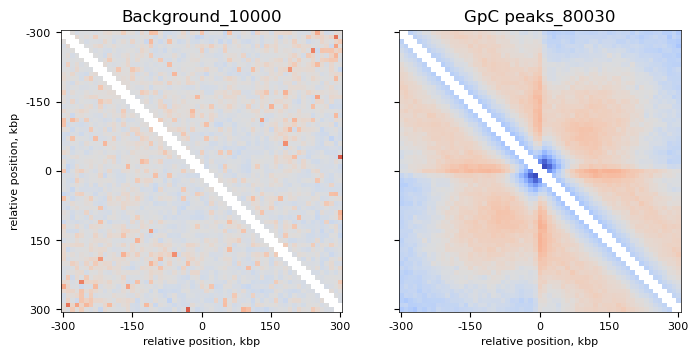

In [20]:
## Background and GpC peaks
# gmpeaks_mat = cooltools.pileup(c1, gmpeakdf,  view_df=hg38_arms, 
#                          expected_df=c1_expected, flank=300_000,  nproc=20)
# bk_mat = cooltools.pileup(c1, bkg_df,  view_df=hg38_arms, 
#                          expected_df=c1_expected, flank=300_000,  nproc=12)
### plot
groups = ['Background', 'GpC peaks']
n_groups = 2
flank=300_000
resolution = 10_000
ticks_pixels = np.linspace(0, flank*2//resolution, 5 )
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
fig, axs = plt.subplots(1, n_groups, sharex=True, sharey=True, figsize=(4*n_groups, 4))
i = 0
for gID, datamat in zip( groups, [bk_mat, gmpeaks_mat] ):
    mtx=np.nanmean(datamat, axis=0)
    ax = axs[i]
    ax.imshow(np.log2(mtx), 
              vmax = 0.2,
              vmin = -0.2,
              cmap='coolwarm',interpolation='none')
    
    ax.set(title=f'{gID}_{len(datamat)}',
           xticks=ticks_pixels,
           xticklabels=ticks_kbp,
           xlabel='relative position, kbp')
    i += 1

axs[0].set(yticks=ticks_pixels,
       yticklabels=ticks_kbp,
       ylabel='relative position, kbp')
exfile = "/data1/Project/GpC/Fiugres/PileupHeatmap/GM_background_vs_gpc_peaks_pileup.pdf"
# plt.show()
plt.savefig(exfile)